In [11]:
import pandas as pd
import geopandas as gpd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from fiona.drvsupport import supported_drivers
from tqdm.notebook import tqdm
from scipy.spatial import cKDTree
from scipy.stats import norm
import ipywidgets as widgets
from ipywidgets import HBox, Label, IntSlider,IntRangeSlider
import folium
import folium.plugins as plg
from itertools import chain
import scipy.stats as st
import math
import matplotlib as mpl
import branca
from ipywidgets import HTML
from IPython.display import clear_output
from ipyleaflet import Map, basemaps, basemap_to_tiles, CircleMarker, Popup, Polyline,LayerGroup, LayersControl,ScaleControl, FullScreenControl
from ipyleaflet import WidgetControl


In [12]:
# # tmparr=np.random.randint(100, size = (2, 100))
# plt.figure(figsize=(12,12))
# plt.scatter(tmparr[0],tmparr[1],marker='.',color='k',label='Point Scatterer')
# plt.tick_params(left = False, right = False , labelleft = False , 
#                 labelbottom = False, bottom = False) 
# plt.legend()
# # plt.scatter(*np.ranbdom.randint(100, size = (2, 100)))
# # np.random.randint(100, size = (2, 100))

In [13]:
# np.where(np.logical_and(tmparr[0]>60,tmparr[1]<5))[0]

In [14]:
# # plt.scatter(tmparr[0],tmparr[1],marker='.',color='k')
# # plt.plot(tmparr[0,:5],tmparr[1,:5],marker='.',color='k')
# # plt.show()
# # plt.plot(tmparr[0,:6],tmparr[1,:6],marker='.',color='k')
# rps = 24
# plt.figure(figsize=(8,8))
# for i in range(len(tmparr[0])-1):
#     plt.plot([tmparr[0,rps],tmparr[0,i+1]],[tmparr[1,rps],tmparr[1,i+1]],'k:', linewidth=0.2)
# plt.scatter(tmparr[0],tmparr[1],marker='.',color='k',label='Point Scatterer')
# # plt.scatter(tmparr[0,rps],tmparr[1,rps],marker='X',color='red')
# plt.plot(tmparr[0,rps],tmparr[1,rps],'rx',label='Reference Point')
# plt.tick_params(left = False, right = False , labelleft = False , 
#                 labelbottom = False, bottom = False) 
# # plt.legend()
# plt.show()


In [5]:
# get areas of interest
def get_aois(aoi_path):
    # search for kml files in the provided file directory
    kmls = glob.glob(os.path.join(aoi_path, "*.kml"))
    polygons = []
    # the aois are stored as kml files, the file format need to be changed
    # gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
    supported_drivers['KML'] = 'rw'
    for f in kmls:
        # read the kml file
        polygons.append(gpd.read_file(f, driver = 'KML', crs = 'EPSG:4326'))
#         polygons.append(gpd.read_file(f))#, driver = 'ESRI Shapefile', crs = 'EPSG:4326'))

    #get all the aois that are loaded   
    aois = pd.concat(polygons)
    aois = aois.to_crs(28992)
    return aois


def temporally_data_points(insar_gpd_ex, aoi_ex):
    # select proper data points (so only the data points that are within the aoi)
    #insar_gpd_selection = gpd.sjoin(insar_gpd, aoi, how = 'inner', predicate = 'within')
    insar_gpd_selection = gpd.sjoin(insar_gpd_ex, aoi_ex)
    
    return insar_gpd_selection


In [6]:
%%time

#load InSAR file as dataframe
df = pd.read_csv('insar_gpd.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)

#convert dataframe to geodataframe
gdf = gpd.GeoDataFrame(df, crs='epsg:28992')

CPU times: total: 22.7 s
Wall time: 24.5 s


In [7]:
%%time

#select kml file (aoi polygon)
aoi_path = "./AOI"
# aoi_name =  "case_grim" 
aoi_name =  "Quaywall1"
# aoi_name = "ex_psi"

aois = get_aois(aoi_path)
aoi = aois[aois.Name == aoi_name]

#clip InSAR data over aoi polygon (kml file)
insar_gpd_selection = temporally_data_points(gdf, aoi) 




CPU times: total: 12.8 s
Wall time: 14.4 s


In [8]:
# compute time arrays (temporal baseline)
time_insar_data = pd.to_datetime(tuple(map(lambda f: f[2:], filter(lambda f: f[0] == 'd', insar_gpd_selection.columns))))
num_time_data = np.array((time_insar_data - time_insar_data[0])/pd.Timedelta(days =1))

# # create amplitude filter (needed in later stage to only extract the amplitude data)
filter_ampl = [col for col in insar_gpd_selection if col.startswith('a_')]

# create displacements filter (needed in later stage to only extract displacement data)
filter_def = [col for col in insar_gpd_selection if col.startswith('d_')]


In [16]:
#Postion of PS ( in EPSG:28992 )
x_t  = insar_gpd_selection.geometry.apply(lambda p: p.x).to_numpy()
y_t  = insar_gpd_selection.geometry.apply(lambda p: p.y).to_numpy()

#Postion of PS as coordinated
pnt_t  = np.vstack((x_t ,y_t )).T

#Set maximum length of arcs in meters
Max_range = 60 

#converting coordinate data in KD-Tree format
kt = cKDTree(pnt_t)

#arc tuple generation
pr =  kt.query_pairs(Max_range, output_type='ndarray')

#calculating number of arcs (tuples) formed
org_num_arc = pr.shape[0]

#Distance, Velocity, Azimuth and Elevation angle calculation
dis = np.sqrt(np.sum((pnt_t[pr[:,0]] -pnt_t[pr[:,1]])**2,axis =1))
az_a = np.degrees(np.arctan2((pnt_t[pr[:,0]][:,0]-pnt_t[pr[:,1]][:,0]),(pnt_t[pr[:,0]][:,1]-pnt_t[pr[:,1]][:,1])))
elevation_arc = np.array(insar_gpd_selection.iloc[pr[:,0]].pnt_height) - np.array(insar_gpd_selection.iloc[pr[:,1]].pnt_height)


#position of the arcs
posix = pnt_t[pr[:,0]][:,0] 
posiy = pnt_t[pr[:,0]][:,1] 

#Displacement timeseries of PS (w.r.t. ref. point)
def_t = np.array(insar_gpd_selection[filter_def])

#Amplitude timeseries of PS
# amp_t = np.array(insar_gpd_selection[filter_ampl])


In [17]:
## Rotation - coordinate coverion to local reference (example respect to angle of canal) 

aoi_name =  "Quay1" 
aoi = aois[aois.Name == aoi_name]


xx = aoi.iloc[0].geometry.xy[0]
yy = aoi.iloc[0].geometry.xy[1]
az_a = az_a - np.degrees(np.arctan((xx[0]-xx[1])/(yy[0]-yy[1])))


x_t  = insar_gpd_selection.geometry.apply(lambda p: p.x).to_numpy()
y_t  = insar_gpd_selection.geometry.apply(lambda p: p.y).to_numpy()


# aois = get_aois(aoi_path)
aoi = aois[aois.Name == "Quay1"]
line_inf = np.array(aoi.iloc[0]['geometry'].coords.xy)

#(line_inf.T - line_inf[:,0]).T
# np.degrees(np.arctan2((line_inf[1,1]-line_inf[1,0]),(line_inf[0,1]-line_inf[0,0])))
    
line_inf[:,0]
rot_ang =np.pi*2 + np.arctan2((line_inf[1,1]-line_inf[1,0]),(line_inf[0,1]-line_inf[0,0])) 
rot_ang = -rot_ang
rot_mat = [[np.cos(rot_ang), -np.sin(rot_ang)]
          ,[np.sin(rot_ang), np.cos(rot_ang)]]

# print(rot_mat @ (line_inf.T -  line_inf[:,0]).T)

# plt.scatter((line_inf.T -  line_inf[:,0]).T[0],(line_inf.T -  line_inf[:,0]).T[1])
# plt.scatter((rot_mat @ (line_inf.T -  line_inf[:,0]).T)[0],(rot_mat @ (line_inf.T -  line_inf[:,0]).T)[1])

temp_pnt = (np.array([x_t,y_t]).T - line_inf[:,0]).T
temp_pnt = rot_mat @ temp_pnt
pnt_rot = np.array([temp_pnt[1],temp_pnt[0]])
del temp_pnt

# plt.figure(figsize= (12,2))
# plt.scatter(pnt_rot[1],pnt_rot[0])

In [18]:
#ESTIMATE DISPLACEMENT PARAMETERS USING MHT FOR PS W.R.T. REF POINT

#displacement timeseries in mm
y = def_t[:]*1e3

## FUNCTIONAL MODELS
# H_0 : Linear + Constant
A = np.vstack([num_time_data,np.ones(len(num_time_data))]).T 

# H_j 
C_list = []

## Periodic
temp_C = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T   
C_list.append(temp_C)

## Periodic + Step
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),3))
    temp_C[:,:2] = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T   
    temp_C[t:,2]=np.ones(len(num_time_data[t:]))
    C_list.append(temp_C)

## Step    
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),1))
    temp_C[t:,0]=np.ones(len(num_time_data[t:]))
    C_list.append(temp_C)
    
## Breakpoint
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),1))
    temp_C[t:,0]=num_time_data[t:] - num_time_data[t-1]
    C_list.append(temp_C)
    
# ## Breakpoint + Seasonal
# for t in range(10,len(num_time_data)-10):
#     temp_C = np.zeros((len(num_time_data),4))
#     temp_C[:t,0]=num_time_data[:t] - num_time_data[t-1]
#     temp_C[t:,1]=num_time_data[t:] - num_time_data[t-1]
#     temp_C[:,2:4] = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T
# #     temp_C[:,2] = num_time_data[:]
#     C_list.append(temp_C)

    
## STOCHASTIC MODEL    
#Unit variance
sigma_sq = 3**2
#VCM
Q_yy = sigma_sq * np.identity(len(num_time_data))
Q_yy_inv = np.linalg.inv(Q_yy)

#Residual for H_0
e_hat = y.T - A @ np.linalg.inv((A.T @ Q_yy_inv @ A)) @ A.T @ Q_yy_inv @ y.T

Q_ee = Q_yy - A @ np.linalg.inv((A.T @ Q_yy_inv @ A)) @ A.T

#Initialize array of optimal models (entire array is initialize as -1)
Optimal_model_ps = np.ones(len(y))*-1


## Critical values (Using pre-calculated values - Obtained using)
kOMT = 207.4554

kb =   np.array([9.1497,
                10.1682,
                11.1847,
                12.1995,
                13.2128,
                14.2249,
                15.2360,
                16.2461,
                17.2554,
                18.2640,
                19.2719,
                20.2793,
                21.2862,
                22.2926,
                23.2986,
                24.3042,
                25.3095,
                26.3145,
                27.3192,
                28.3236])


## Overall Model Test 
OMT_T_q = np.empty(len(y))
for i in range(len(y)):
    OMT_T_q[i] = e_hat[:,i].T @ Q_yy_inv @ e_hat[:,i]
    
# Points that fail overall model test
Ha_series = np.where( OMT_T_q > kOMT)[0]
      

#calculate test statistic
T_q = np.empty((len(Ha_series),len(C_list)))
for j in tqdm(range(len(C_list))):    
    temp_T = []
    C =  C_list[j]
    L = Q_yy_inv @ C @ np.linalg.inv(C.T @ Q_yy_inv @ Q_ee @ Q_yy_inv @ C) @ C.T @ Q_yy_inv
    for i in range(len(Ha_series[:])):
        T_q[i,j] = e_hat[:,Ha_series[i]].T @ L @ e_hat[:,Ha_series[i]]
        
#dimesion or number of additional parameters in alternate hypothesis
q = np.array(list(map(np.shape,C_list)))[:,1]
        
## Test Statistic ratio
T_q_ratio = T_q/kb[q-1]

#Initialize array of optimal hypothesis 
Opt_hyp_ps = np.zeros(len(y))

T_q_ratio[np.where(T_q_ratio>1)[0],np.where(T_q_ratio>1)[1]]=0
for i in range(T_q.shape[0]):
    if np.sum(T_q_ratio[i,:]!=0)>0:
        Optimal_model_ps[Ha_series[i]] = np.where(T_q_ratio[i,:]==np.max(T_q_ratio[i,:]))[0][0]
        if Optimal_model_ps[Ha_series[i]] == 0: 
            Opt_hyp_ps[Ha_series[i]] = 1
        else:
            Opt_hyp_ps[Ha_series[i]] = np.ceil(Optimal_model_ps[Ha_series[i]]/181) +1
    else :
        Opt_hyp_ps[Ha_series[i]] = 0


##CALCULATING DISPLACEMENT PARAMETERS
C_list = []

## Periodic
temp_C = np.zeros((len(num_time_data),4))    
temp_C[:,:2] = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T   
temp_C[:,2] = num_time_data[:]
temp_C[:,3] = np.ones(len(num_time_data))
C_list.append(temp_C)

## Periodic + Step
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),5))
    temp_C[:,:2] = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T   
    temp_C[t:,2]=np.ones(len(num_time_data[t:]))
    temp_C[:,3] = num_time_data[:]
    temp_C[:,4] =np.ones(len(num_time_data))
    C_list.append(temp_C)

## Step    
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),3))
    temp_C[t:,0]=np.ones(len(num_time_data[t:]))
    temp_C[:,1] = num_time_data[:]
    temp_C[:,2] =np.ones(len(num_time_data))
    C_list.append(temp_C)
    
## Breakpoint
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),3))
#     temp_C[:t,0]=num_time_data[:t] - num_time_data[t-1]
    temp_C[t:,0]=num_time_data[t:] - num_time_data[t-1]
    temp_C[:,1] = num_time_data[:]
    temp_C[:,2] =np.ones(len(num_time_data))
    C_list.append(temp_C)

# ## Breakpoint + Seasonal
# for t in range(10,len(num_time_data)-10):
#     temp_C = np.zeros((len(num_time_data),5))
#     temp_C[:t,0]=num_time_data[:t] - num_time_data[t-1]
#     temp_C[t:,1]=num_time_data[t:] - num_time_data[t-1]
#     temp_C[:,2:4] = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T
#     temp_C[:,4] = num_time_data[:]
#     C_list.append(temp_C)

## Calculate optimal parameters
Opt_para_ps = []
C_list.append(A)
for i in tqdm(range(y.shape[0])):
    C = C_list[int(Optimal_model_ps[i])]
    Opt_para_ps.append(np.linalg.inv(C.T @ Q_yy_inv @ C) @ C.T @ Q_yy_inv @ y[i])    

  0%|          | 0/544 [00:00<?, ?it/s]

  0%|          | 0/2472 [00:00<?, ?it/s]

In [19]:
#ESTIMATE DISPLACEMENT PARAMETERS USING MHT FOR ARCS

#displacement timeseries of arcs in mm
y= (def_t[pr[:,0]] -  def_t[pr[:,1]])*1e3


## FUNCTIONAL MODELS
## H_0 : Linear + Constant
A = np.vstack([num_time_data, np.ones(len(num_time_data))]).T   

## H_j 
# List of alternate models
C_list = []

## Periodic
temp_C = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T   
# temp_C = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T   
C_list.append(temp_C)

## Periodic + Step
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),3))
    temp_C[:,:2] = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T   
    temp_C[t:,2]=np.ones(len(num_time_data[t:]))
    C_list.append(temp_C)

## Step    
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),1))
    temp_C[t:,0]=np.ones(len(num_time_data[t:]))
    C_list.append(temp_C)
    
## Breakpoint
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),1))
#     temp_C[:t,0]=num_time_data[:t] - num_time_data[t-1]
    temp_C[t:,0]=num_time_data[t:] - num_time_data[t-1]
#     temp_C[:,2] = num_time_data[:]
    C_list.append(temp_C)
    

## STOCHASTIC MODEL    
#Unit variance
sigma_sq = (3)**2#(4.5)**2
#VCM
Q_yy = sigma_sq * np.identity(len(num_time_data))
Q_yy_inv = np.linalg.inv(Q_yy)

## Residual for H_0
e_hat = y.T - A @ np.linalg.inv((A.T @ Q_yy_inv @ A)) @ A.T @ Q_yy_inv @ y.T

Q_ee = Q_yy - A @ np.linalg.inv((A.T @ Q_yy_inv @ A)) @ A.T

#Initialize array of optimal models (entire array is initialize as -1)
Optimal_model = np.ones(len(y))*-1


## Critical values (Using pre-calculated values - Obtained from )
kOMT = 207.4554#205.4369

kb =   np.array([9.1497,
                10.1682,
                11.1847,
                12.1995,
                13.2128,
                14.2249,
                15.2360,
                16.2461,
                17.2554,
                18.2640,
                19.2719,
                20.2793,
                21.2862,
                22.2926,
                23.2986,
                24.3042,
                25.3095,
                26.3145,
                27.3192,
                28.3236])

## Overall Model Test 
OMT_T_q = np.empty(len(y))
for i in tqdm(range(len(y))):
    OMT_T_q[i] = e_hat[:,i].T @ Q_yy_inv @ e_hat[:,i]
    
# Points that failed overall model test
Ha_series = np.where( OMT_T_q > kOMT)[0]

#calculate test statistic
T_q = np.empty((len(Ha_series),len(C_list)))
for j in tqdm(range(len(C_list))):    
    temp_T = []
    C =  C_list[j]
    L = Q_yy_inv @ C @ np.linalg.inv(C.T @ Q_yy_inv @ Q_ee @ Q_yy_inv @ C) @ C.T @ Q_yy_inv
    for i in range(len(Ha_series[:])):
        T_q[i,j] = e_hat[:,Ha_series[i]].T @ L @ e_hat[:,Ha_series[i]]

#dimesion or number of additional parameters in alternate hypothesis        
q = np.array(list(map(np.shape,C_list)))[:,1]
        
## Test Statistic
T_q_ratio = T_q/kb[q-1]

#Initialize array of optimal hypothesis 
Opt_hyp = np.zeros(len(y))

T_q_ratio[np.where(T_q_ratio<1)[0],np.where(T_q_ratio<1)[1]]=0
for i in range(T_q.shape[0]):
    if np.sum(T_q_ratio[i,:]!=0)>0:
        Optimal_model[Ha_series[i]] = np.where(T_q_ratio[i,:]==np.max(T_q_ratio[i,:]))[0][0]
        if Optimal_model[Ha_series[i]] == 0: 
            Opt_hyp[Ha_series[i]] = 1
        else:
            Opt_hyp[Ha_series[i]] = np.ceil(Optimal_model[Ha_series[i]]/int((len(C_list)-1)/3)) +1
    else :
        Opt_hyp[Ha_series[i]] = 0

##CALCULATING DISPLACEMENT PARAMETERS
C_list = []

## Periodic
temp_C = np.zeros((len(num_time_data),4))    
temp_C[:,:2] = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T   
temp_C[:,2] = num_time_data[:]
temp_C[:,3] = np.ones(len(num_time_data))
C_list.append(temp_C)

## Periodic + Step
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),5))
    temp_C[:,:2] = np.vstack([np.sin(2*math.pi*(num_time_data/365)), np.cos(2*math.pi*(num_time_data/365))-1]).T   
    temp_C[t:,2]=np.ones(len(num_time_data[t:]))
    temp_C[:,3] = num_time_data[:]
    temp_C[:,4] =np.ones(len(num_time_data))
    C_list.append(temp_C)

## Step    
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),3))
    temp_C[t:,0]=np.ones(len(num_time_data[t:]))
    temp_C[:,1] = num_time_data[:]
    temp_C[:,2] =np.ones(len(num_time_data))
    C_list.append(temp_C)
    
## Breakpoint
for t in range(10,len(num_time_data)-10):
    temp_C = np.zeros((len(num_time_data),3))
#     temp_C[:t,0]=num_time_data[:t] - num_time_data[t-1]
    temp_C[t:,0]=num_time_data[t:] - num_time_data[t-1]
    temp_C[:,1] = num_time_data[:]
    temp_C[:,2] =np.ones(len(num_time_data))
    C_list.append(temp_C)

     
## Calculate optimal parameters
Opt_para = []
C_list.append(A)
for i in tqdm(range(y.shape[0])):
    C = C_list[int(Optimal_model[i])]
    Opt_para.append(np.linalg.inv(C.T @ Q_yy_inv @ C) @ C.T @ Q_yy_inv @ y[i])    

  0%|          | 0/187484 [00:00<?, ?it/s]

  0%|          | 0/544 [00:00<?, ?it/s]

  0%|          | 0/187484 [00:00<?, ?it/s]

In [20]:
## POSTERIOR VARIANCE FOR PS (w.r.t. ref point)
var_f_ps = np.zeros(def_t.shape[0])
for i in tqdm(range(def_t.shape[0])):
    a = i
    y = def_t[pr[a,0]]*1e3
    e = y - C_list[int(Optimal_model_ps[pr[a,0]])]@Opt_para_ps[pr[a,0]]
    q = C_list[int(Optimal_model_ps[a])].shape[0] - C_list[int(Optimal_model_ps[a])].shape[1]
    # C_list[int(Optimal_model_ps[pr[a,0]])]@Opt_para_ps[pr[a,0]]
    var_f_ps[a] = (e.T@Q_yy_inv@e)/q

  0%|          | 0/2472 [00:00<?, ?it/s]

In [21]:
## POSTERIOR VARIANCE FOR ARCS
var_f = np.zeros(pr.shape[0])
for a in tqdm(range(pr.shape[0])):
#     a = i
    y = def_t[pr[a,0]]*1e3 - def_t[pr[a,1]]*1e3
    e = y - C_list[int(Optimal_model[a])]@Opt_para[a]
    q = C_list[int(Optimal_model[a])].shape[0] - C_list[int(Optimal_model[a])].shape[1]
    # C_list[int(Optimal_model_ps[pr[a,0]])]@Opt_para_ps[pr[a,0]]
    var_f[a] = (e.T@Q_yy_inv@e)/q

  0%|          | 0/187484 [00:00<?, ?it/s]

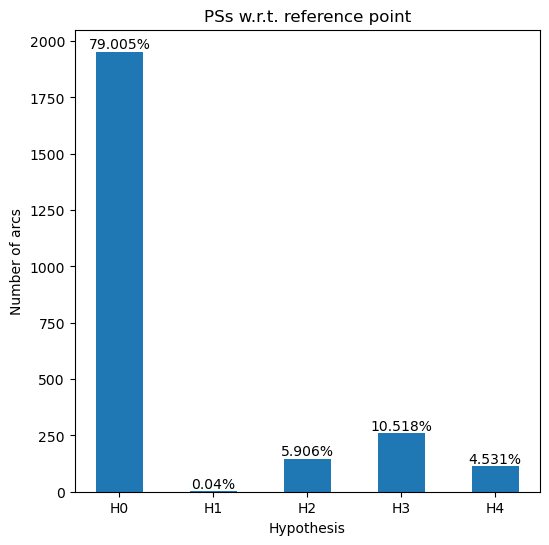

In [22]:
a_t,b_t =  np.unique(Opt_hyp_ps, return_counts=True)
# plt.hist(Opt_hyp)


# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], str(round(float(y[i]*100/np.sum(b_t)),3))+'%', ha = 'center', va = 'bottom')
 
   
# creating data on which bar chart will be plot
x = ['H0','H1','H2','H3','H4']
# y = [b_t[0],b_t[1],b_t[2],0,b_t[3]]
y = b_t
# setting figure size by using figure() function
plt.figure(figsize = (6, 6))

# making the bar chart on the data
plt.bar(x, y,width=0.5)

# calling the function to add value labels
addlabels(x, y)

# giving title to the plot
plt.title("PSs w.r.t. reference point")

# giving X and Y labels
plt.xlabel("Hypothesis")
plt.ylabel("Number of arcs")

# visualizing the plot
plt.show()

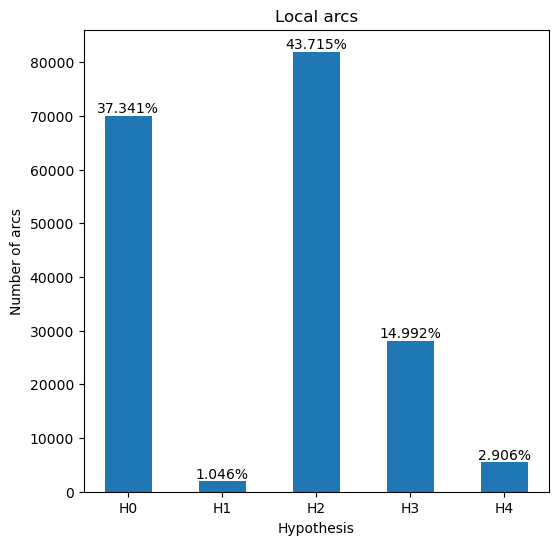

In [24]:
a_t,b_t =  np.unique(Opt_hyp, return_counts=True)
# plt.hist(Opt_hyp)


# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], str(round(float(y[i]*100/np.sum(b_t)),3))+'%', ha = 'center', va = 'bottom')
 
   
# creating data on which bar chart will be plot
x = ['H0','H1','H2','H3','H4']
# y = [b_t[0],b_t[1],b_t[2],0,b_t[3]]
y = b_t
# setting figure size by using figure() function
plt.figure(figsize = (6, 6))

# making the bar chart on the data
plt.bar(x, y,width=0.5)

# calling the function to add value labels
addlabels(x, y)

# giving title to the plot
plt.title("Local arcs")

# giving X and Y labels
plt.xlabel("Hypothesis")
plt.ylabel("Number of arcs")

# visualizing the plot
plt.show()

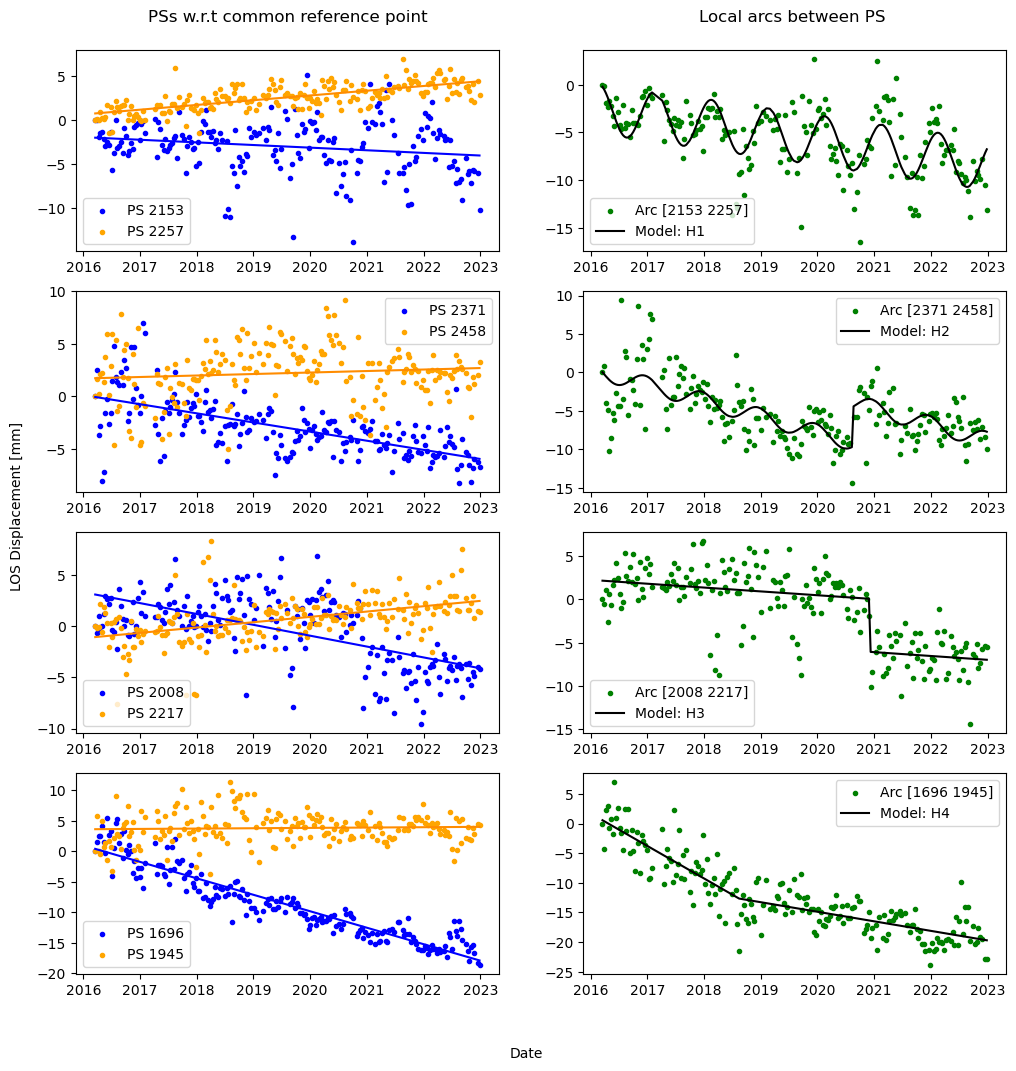

In [25]:
# aa =  20874#38321# 35297 #37021 #38781
# b =  13811 #99791 #20
# c=  893#49970#893#349 #65099
# d=  1847#3013

aa = 25354 #13
b =  1077 #99791 #20
c=  9795 #9794#893#49970#893#349 #65099
d=  43548 #37134#90875#1847#3013



fig, axs = plt.subplots(4, 2,figsize =(12,12))
# pts = [ 8038, 41, 1755, 126]
pts = [ aa, b, c, d]

for i in range(4):
    a = pts[i]
    y = def_t[pr[a,0]]*1e3 - def_t[pr[a,1]]*1e3
    
    axs[i, 1].scatter(time_insar_data, y,marker='.',c = 'green',label = 'Arc '+str(pr[a]))
    axs[i, 1].plot(time_insar_data, C_list[int(Optimal_model[a])]@Opt_para[a],'k',label='Model: H'+str(int(Opt_hyp[a])))
#     axs[i, 1].text(time_insar_data[100], -13,s='Arc posterior sigma:'+str(round(var_f[pts[i]],2)))

    axs[i, 0].scatter(time_insar_data, def_t[pr[a,0]]*1e3,marker='.',label = 'PS '+str(pr[a,0]),c = 'blue')
    axs[i, 0].plot(time_insar_data, C_list[int(Optimal_model_ps[pr[a,0]])]@Opt_para_ps[pr[a,0]],'blue')
#     axs.text('Posterior sigma at '+str(pr[a,0])+': '+var_f_ps[pr[a,0]])
    
    
    
    
    
    axs[i, 0].scatter(time_insar_data, def_t[pr[a,1]]*1e3,marker='.',label = 'PS '+str(pr[a,1]),c = 'orange')
    axs[i, 0].plot(time_insar_data, C_list[int(Optimal_model_ps[pr[a,1]])]@Opt_para_ps[pr[a,1]],'darkorange')
#     axs.text('Posterior sigma at '+str(pr[a,1])+': '+var_f_ps[pr[a,1]])
    
    axs[i,1].legend()
    axs[i,0].legend()

for i in range(4):
    for j in range(2):
        ax = axs[i,j]
        if i == 0 and j ==0:
            title = ax.set_title("PSs w.r.t common reference point", loc='center', y=1.1)
        elif i == 0 and j ==1:
            title = ax.set_title("Local arcs between PS ", loc='center', y=1.1)
    
    

# axs[0, 1].scatter(num_time_data, y[a],marker='.',c = 'green')
# axs[0, 1].plot(num_time_data, C_list[int(Optimal_model[a])]@Opt_para[a],'k')

# axs[0, 0].scatter(num_time_data, def_t[pr[a,0]]*1e3,marker='.')
# axs[0, 0].plot(num_time_data, C_list[int(Optimal_model_ps[pr[a,0]])]@Opt_para_ps[pr[a,0]],'k')

# axs[0, 0].scatter(num_time_data, def_t[pr[a,1]]*1e3,marker='.')
# axs[0, 0].plot(num_time_data, C_list[int(Optimal_model_ps[pr[a,1]])]@Opt_para_ps[pr[a,1]],'k')


# axs[1, 1].scatter(num_time_data, y[b],marker='.',c = 'green')
# axs[1, 1].plot(num_time_data, C_list[int(Optimal_model[b])]@Opt_para[b],'k')

# axs[1, 0].scatter(num_time_data, def_t[pr[b,0]]*1e3,marker='.')
# axs[1, 0].plot(num_time_data, C_list[int(Optimal_model_ps[pr[b,0]])]@Opt_para_ps[pr[b,0]],'k')

# axs[1, 0].scatter(num_time_data, def_t[pr[b,1]]*1e3,marker='.')
# axs[1, 0].plot(num_time_data, C_list[int(Optimal_model_ps[pr[b,1]])]@Opt_para_ps[pr[b,1]],'k')


# axs[2, 1].scatter(num_time_data, y[c],marker='.',c = 'green')
# axs[2, 1].plot(num_time_data, C_list[int(Optimal_model[c])]@Opt_para[c],'k')

# axs[2, 0].scatter(num_time_data, def_t[pr[c,0]]*1e3,marker='.')
# axs[2, 0].plot(num_time_data, C_list[int(Optimal_model_ps[pr[c,0]])]@Opt_para_ps[pr[c,0]],'k')

# axs[2, 0].scatter(num_time_data, def_t[pr[c,1]]*1e3,marker='.')
# axs[2, 0].plot(num_time_data, C_list[int(Optimal_model_ps[pr[c,1]])]@Opt_para_ps[pr[c,1]],'k')


# axs[3, 1].scatter(num_time_data, y[d],marker='.',c = 'green')
# axs[3, 1].plot(num_time_data, C_list[int(Optimal_model[d])]@Opt_para[d],'k')

# axs[3, 0].scatter(num_time_data, def_t[pr[d,0]]*1e3,marker='.')
# axs[3, 0].plot(num_time_data, C_list[int(Optimal_model_ps[pr[d,0]])]@Opt_para_ps[pr[d,0]],'k')

# axs[3, 0].scatter(num_time_data, def_t[pr[d,1]]*1e3,marker='.')
# axs[3, 0].plot(num_time_data, C_list[int(Optimal_model_ps[pr[d,1]])]@Opt_para_ps[pr[d,1]],'k')

# fig.etxt("Date")
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.07, 0.5, 'LOS Displacement [mm]', va='center', rotation='vertical')

plt.show()
